In [8]:
import os
import re
from typing import List, Optional, Tuple, Union

import click
import dnnlib
import numpy as np
import PIL.Image
import torch

from pbw_utils import nethook
import legacy

In [2]:
network_pkl="https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl"
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl"...


In [3]:
def make_transform(translate: Tuple[float,float], angle: float):
    m = np.eye(3)
    s = np.sin(angle/360.0*np.pi*2)
    c = np.cos(angle/360.0*np.pi*2)
    m[0][0] = c
    m[0][1] = s
    m[0][2] = translate[0]
    m[1][0] = -s
    m[1][1] = c
    m[1][2] = translate[1]
    return m

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


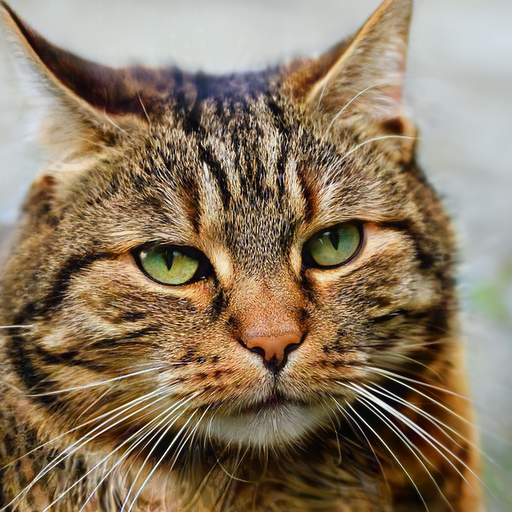

In [4]:
label = torch.zeros([1, G.c_dim], device=device)

#random z
z = torch.from_numpy(np.random.RandomState(2).randn(1, G.z_dim)).to(device)
# Construct an inverse rotation/translation matrix and pass to the generator.  The
# generator expects this matrix as an inverse to avoid potentially failing numerical
# operations in the network.
if hasattr(G.synthesis, 'input'):
    m = make_transform((0,0), 0)
    m = np.linalg.inv(m)
    G.synthesis.input.transform.copy_(torch.from_numpy(m))

img = G(z, label, truncation_psi=1, noise_mode='const')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')#.save(f'{outdir}/seed{seed:04d}.png')
display(img)

In [23]:
#retrieve w
print(G.mapping)
with nethook.Trace(G, "mapping") as wlayer:
    img = G(z, label, truncation_psi=1, noise_mode='const')
    w = wlayer.output


MappingNetwork(
  z_dim=512, c_dim=0, w_dim=512, num_ws=16
  (fc0): FullyConnectedLayer(in_features=512, out_features=512, activation=lrelu)
  (fc1): FullyConnectedLayer(in_features=512, out_features=512, activation=lrelu)
)


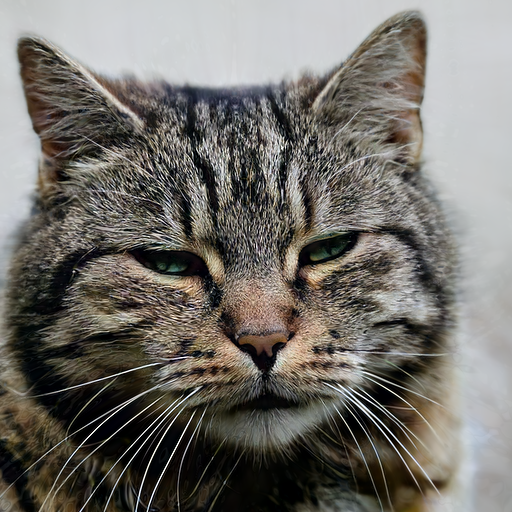

In [25]:
#manipulate w and synthesize from w

w_new = w+torch.from_numpy(np.random.RandomState(4).randn(1, 512)).to(device).repeat([1, 16, 1]) 
img = G.synthesis(w_new)
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')#.save(f'{outdir}/seed{seed:04d}.png')
display(img)